In [73]:
words = open('names.txt', 'r').read().splitlines() 

In [74]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [75]:
len(words)

32033

In [76]:
min(len(word) for word in words)

2

In [77]:
max(len(word) for word in words)

15

In [78]:
# b = {}
# for w in words:
#     chs = ['<S>'] + list(w) + ['<E>']
#     for ch1, ch2 in zip(chs, chs[1:]):
#         bigram = (ch1, ch2)
#         b[bigram] = b.get(bigram, 0) + 1
#         # print(ch1, ch2)

In [79]:
# sorted(b.items(), key = lambda kv: -kv[1])

In [80]:
import torch

In [81]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {v: k for k, v in stoi.items()}

In [82]:
# create training set of bigrams
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1,ch2)
        xs.append(ix1)
        ys.append(ix2)


xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [83]:
xs

tensor([ 0,  5, 13, 13,  1])

In [84]:
ys

tensor([ 5, 13, 13,  1,  0])

In [85]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float() # turns the xs into a matrix which activates a particular element for easier operations
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [86]:
xenc.shape

torch.Size([5, 27])

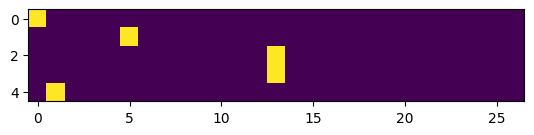

In [87]:
import matplotlib.pyplot as plt
plt.imshow(xenc)

In [88]:
xenc.dtype

torch.float32

In [89]:
g = torch.Generator().manual_seed(1337)

W = torch.randn((27, 27), generator=g)
xenc @ W # matrix multiplication (5, 27) @ (27, 27)

In [90]:
(xenc @ W)[3, 13]

tensor(1.6685)

In [91]:
(xenc @ W)[3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [92]:
W[:, 13]

tensor([-0.2398, -0.5075, -0.0646, -1.0012,  0.2807, -0.1140, -1.3849,  1.1169,
         0.8216,  0.4562, -2.8272,  1.1088, -2.1608,  1.6685,  0.3362, -2.1821,
         0.6151,  0.0286, -2.1749, -0.1217, -1.2273,  0.1588, -0.4876, -0.1305,
        -1.2803,  0.6117,  0.2877])

In [93]:
(xenc[3] * W[:, 13]).sum()

tensor(1.6685)

In [102]:
logits = xenc @ W
# exponentiated outputs have only positive numbers & range from 0 to +inf
# x<0 gives us y<1, x>0 gives us y>0 growing to +inf
counts = logits.exp() # equiv of the N matrix in the bigram
print(counts)
probs = counts / counts.sum(1, keepdims=True)
print(probs)

tensor([[ 1.1981,  0.9324,  0.6979,  0.4004,  1.8697,  1.0258,  2.5974,  1.0665,
          1.4350,  3.2152,  0.2593,  0.6004,  1.2661,  0.7868,  0.3981,  4.6800,
          3.8529,  0.8697,  1.3308,  2.6251,  0.1304,  1.6374,  4.4238,  1.8059,
          1.1343,  0.2096,  0.3135],
        [ 0.1859,  0.9737,  1.0769,  2.8626,  1.9697,  1.3589,  0.4737,  2.1033,
          2.4294,  9.8497,  2.6147,  0.2166,  0.7473,  0.8923,  0.7308,  0.5330,
          3.1221,  0.3711,  1.1853,  3.4037,  0.7909,  0.3474,  0.5198,  4.9081,
          0.4968,  0.4082,  1.0684],
        [ 0.4496,  1.3394,  3.7222,  3.5278,  0.7044,  0.1267,  2.8792,  0.3474,
          2.6941,  0.9234,  2.9302,  1.2689,  1.7784,  5.3042,  1.8177,  0.1536,
          3.6366,  0.6871,  0.1504,  1.7431,  2.3554,  0.4291,  1.6512,  0.3807,
          0.4841,  1.1041,  1.8091],
        [ 0.4496,  1.3394,  3.7222,  3.5278,  0.7044,  0.1267,  2.8792,  0.3474,
          2.6941,  0.9234,  2.9302,  1.2689,  1.7784,  5.3042,  1.8177,  0.1536

In [103]:
print(f'{probs[0].sum()=}, {probs.shape=}') # every row sums to one, with shape 5x27

probs[0].sum()=tensor(1.0000), probs.shape=torch.Size([5, 27])


In [104]:
xs

tensor([ 0,  5, 13, 13,  1])

In [105]:
ys

tensor([ 5, 13, 13,  1,  0])

In [122]:
# randomly initialize 27 neurons weights, each neuron receives 27 inputs
g = torch.Generator().manual_seed(1337)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [140]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network - one-hot encoding - https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html
logits = xenc @ W # predicts log-counts
counts = logits.exp() # counts, equiv to N in the bigram
probs = counts/counts.sum(1,keepdims=True) # normalize counts, probs for the next char
# counts & probs are also called "softmax"
loss = -probs[torch.arange(5), ys].log().mean() # a.k.a. nll

In [141]:
probs.shape

torch.Size([5, 27])

In [142]:
# # 'emma' bigram example
# nlls = torch.zeros(5)
# for i in range(5):
#   # i-th bigram
#   x = xs[i].item() # input character index
#   y = ys[i].item() # label character index
#   print('---')
#   print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
#   print('input to the neural net:', x)
#   print('output probs from the neural net:', probs[i])
#   print('label (actual next char):', y)
#   p = probs[i, y]
#   print('probability assigned by the net to the correct character:', p.item())
#   logp = torch.log(p)
#   print('log likelihood:', logp.item())
#   nll = -logp
#   print('negative log likelihood:', nll.item())
#   nlls[i] = nll

# print('===')
# print(f'avg nll (loss): {nlls.mean().item()}')

In [143]:
# backward pass
W.grad = None # set gradient to zero
loss.backward()

In [144]:
print(loss)

tensor(3.4782, grad_fn=<NegBackward0>)


In [137]:
W.shape

torch.Size([27, 27])

In [138]:
W.grad.shape

torch.Size([27, 27])

In [139]:
W.data += -0.1 * W.grad

In [145]:
# ---- actual gradient descent ----

In [171]:
# create dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('num of examples: ', num)

# initialize network
g = torch.Generator().manual_seed(1337)
W = torch.randn((27, 27), generator=g, requires_grad=True)

num of examples:  228146


In [188]:
# gradient descent
reg_strength = 0.01

for k in range(1000):
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network - one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equiv to N in the bigram
  probs = counts/counts.sum(1,keepdims=True) # normalize counts, probs for the next char
  loss = -probs[torch.arange(num), ys].log().mean() + reg_strength * (W**2).mean() # a.k.a. nll; (W**2).mean() is for regularization, i.e. to prevent the probabilities from becoming too extreme (infinite), also fights overfitting; reg_strength is a hyperparameter
  # print(loss.item())

  # backward pass
  W.grad = None # set gradient to zero
  loss.backward()

  # update
  W.data += -50 * W.grad
print(loss.item())

2.4803988933563232


In [193]:
# sample neural net
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  out =[]
  ix = 0
  while True:
    # before:
    # p = P[ix]
    # now:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equiv to N in the bigram
    p = counts/counts.sum(1, keepdims=True) # normalize counts, probs for the next char

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.


In [ ]:
# result from bigram model:
# cexze.
# momasurailezitynn.
# konimittain.
# llayn.
# ka.

# surprise (not really) - current neural net works the same as the bigram model